In [1]:
import pinocchio
import numpy as np
import math

In [ ]:
#model_amir = pinocchio.buildModelFromUrdf("/home/carlos/reach_bravo_7_ws/src/reach-bravo-7/bpl_bravo_description/urdf/bravo_7_amir_2.urdf")
model_amir = pinocchio.buildModelFromUrdf("/home/medusa/bravo7_compliance/reach-bravo-7/bpl_bravo_description/urdf/bravo_7_amir_2.urdf")
data_amir = model_amir.createData()
tool_link = "EE"

In [6]:
q_vel = np.array([3, 0.2, 0.5, 0.2, 0.1, 0.2])
home = np.array([0.323, 2.708, 0.5045, 1.9917, 1.6112, 0.2304])

In [7]:
# 1) update kinematics
pinocchio.forwardKinematics(model_amir, data_amir, home, q_vel)
pinocchio.updateFramePlacements(model_amir, data_amir)


In [8]:
# 2) Mass matrix and inverse
M = pinocchio.crba(model_amir, data_amir, home)                  # returns (nv x nv) inertia
# crba returns matrix in data.M or directly? pin.crba returns M and stores also; using return value
# ensure symmetric positive definite -> invert (use solve or pinocchio utility if available)
# We'll invert with regularization for numerical stability:
regularization=1e-6
M_reg = M + regularization * np.eye(model_amir.nv)
M_inv = np.linalg.inv(M_reg)

In [9]:
M-M_reg

array([[-1.e-06,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00, -1.e-06,  0.e+00,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00,  0.e+00, -1.e-06,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00,  0.e+00,  0.e+00, -1.e-06,  0.e+00,  0.e+00],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00, -1.e-06,  0.e+00],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00, -1.e-06]])

In [10]:
# 3) Joint-space nonlinear effects (C(q,v)*v + g(q))
# pinocchio.nonLinearEffects returns the generalized bias forces (nv)
nle = pinocchio.nonLinearEffects(model_amir, data_amir, home, q_vel)   # nv vector

In [11]:

# 4) Frame Jacobian (6 x nv) in chosen reference frame
J = pinocchio.computeFrameJacobian(model_amir, data_amir, home, 43, pinocchio.ReferenceFrame.LOCAL)  # shape (6, nv)


In [12]:
# 5) Jdot * v  (compute time-variation of the Jacobian multiplied by v)
# Pinocchio provides computeFrameJacobianTimeVariation or similar to get Jdot * v
# Implementation note: pin.computeFrameJacobianTimeVariation returns the time variation
try:
    Jdot_v = pinocchio.computeFrameJacobianTimeVariation(model_amir, data_amir, home, q_vel, 43, pinocchio.ReferenceFrame.LOCAL)
except Exception:
    # Different Pinocchio versions sometimes expose this differently:
    # fallback: compute Jdot * v numerically (cheap for small dt) OR zero (conservative)
    # Here we warn and use zeros as conservative fallback:
    Jdot_v = np.zeros(6)

In [13]:
# 6) Task-space inertia matrix Lambda = inv(J M^{-1} J^T)
# Compute the (6x6) matrix and regularize
Lambda_inv = J.dot(M_inv).dot(J.T)
# regularize for numerical stability
Lambda_inv_reg = Lambda_inv + regularization * np.eye(6)
Lambda = np.linalg.inv(Lambda_inv_reg)

In [14]:
# 7) Dynamically-consistent generalized inverse Jbar = M^{-1} J^T Lambda
Jbar = M_inv.dot(J.T).dot(Lambda)   # shape (nv x 6)

# 8) Nullspace projector (joint space) N = I - Jbar * J
N = np.eye(model_amir.nv) - Jbar.dot(J)

In [15]:
# 9) compute current task pose & velocity
# Get frame placement (SE3) and spatial velocity
placement = data_amir.oMf[43]                  # SE3
x_current = placement                            # pin.SE3 object; use .translation / .rotation if needed
v_frame = pinocchio.getFrameVelocity(model_amir, data_amir, 43, pinocchio.ReferenceFrame.LOCAL)  # 6-d spatial velocity
# If getFrameVelocity not available, compute J @ v:


In [ ]:
# x_des        : desired 6D Cartesian pose as pin.SE3 or (3 pos + 3 ori)? (see below)
# 10) compute task-space errors
# Position error:
pos_err = x_des.translation - x_current.translation if isinstance(x_des, pin.SE3) else x_des[:3] - x_current.translation
# Orientation error (use rotation error as 3-vector): r_err = 0.5*(R_des^T * R - R^T * R_des) vee; simpler: use pinocchio.log6?
if isinstance(x_des, pinocchio.SE3):
    R_des = x_des.rotation
    R_cur = x_current.rotation
    # orientation error as 3-vector (approx): use log of relative rotation
    relR = R_des.T.dot(R_cur)    # or R_cur.inverse * R_des depending on convention
    # convert relR to axis-angle vector:
    # pinocchio provides log3 or so; we'll use pin.log6 on SE3 diff if available
    # For robustness use this common formula:
    # r_err = 0.5 * (R_cur[:,0] x R_des[:,0] + ...)
    # To keep this code compact, approximate small-angle error via rotation matrix difference:
    r_err_mat = 0.5 * (R_des.dot(R_cur.T) - R_cur.dot(R_des.T))
    ori_err = np.array([r_err_mat[2,1], r_err_mat[0,2], r_err_mat[1,0]])
else:
    # If x_des given as vector [px,py,pz, rx,ry,rz] with small-angle orientation error:
    ori_err = x_des[3:6] - placement.rotation_vector if hasattr(placement, 'rotation_vector') else np.zeros(3)

x_err = np.concatenate([pos_err, ori_err]).reshape(6)

## wHOLE CODE


```python
import numpy as np
import pinocchio as pin

def operational_space_impedance(
    model, data, q, v,
    frame_id,
    x_des, xd_des, xdd_des,
    M_d, D, K=None,
    tau_null=None,
    regularization=1e-6,
    reference_frame=pin.ReferenceFrame.WORLD
):
    """
    Operational-space mass-damping (impedance) controller with dynamic consistency.

    Inputs:
    - model, data : pinocchio model & data
    - q, v         : joint position (nq) and velocity (nv)
    - frame_id     : frame index of the end-effector
    - x_des        : desired 6D Cartesian pose as pin.SE3 or (3 pos + 3 ori)? (see below)
    - xd_des       : desired 6D Cartesian velocity (6x1) [vx, vy, vz, wx, wy, wz] in reference_frame
    - xdd_des      : desired 6D Cartesian acceleration (6x1)
    - M_d (6x6)    : desired Cartesian inertia matrix (usually diag)
    - D (6x6)      : desired Cartesian damping matrix
    - K (6x6)      : optional stiffness matrix (if None, stiffness=0)
    - tau_null     : optional nullspace torque (nv) for posture control
    - regularization: small value to stabilize inverses
    - reference_frame: pin.ReferenceFrame.WORLD or LOCAL (default WORLD)

    Returns:
    - tau (nv)          : commanded joint torques
    - diagnostics dict with J, Lambda, Jbar, N, F_task, nle
    """

    nq = model.nq
    nv = model.nv

    if K is None:
        K = np.zeros((6,6))

    if tau_null is None:
        tau_null = np.zeros(nv)

    # 1) update kinematics
    pin.forwardKinematics(model, data, q, v)
    pin.updateFramePlacements(model, data, q)     # ensure frame placement is available

    # 2) Mass matrix and inverse
    M = pin.crba(model, data, q)                  # returns (nv x nv) inertia
    # crba returns matrix in data.M or directly? pin.crba returns M and stores also; using return value
    # ensure symmetric positive definite -> invert (use solve or pinocchio utility if available)
    # We'll invert with regularization for numerical stability:
    M_reg = M + regularization * np.eye(nv)
    M_inv = np.linalg.inv(M_reg)

    # 3) Joint-space nonlinear effects (C(q,v)*v + g(q))
    # pinocchio.nonLinearEffects returns the generalized bias forces (nv)
    nle = pin.nonLinearEffects(model, data, q, v)   # nv vector

    # 4) Frame Jacobian (6 x nv) in chosen reference frame
    J = pin.computeFrameJacobian(model, data, q, frame_id, reference_frame)  # shape (6, nv)

    # 5) Jdot * v  (compute time-variation of the Jacobian multiplied by v)
    # Pinocchio provides computeFrameJacobianTimeVariation or similar to get Jdot * v
    # Implementation note: pin.computeFrameJacobianTimeVariation returns the time variation
    try:
        Jdot_v = pin.computeFrameJacobianTimeVariation(model, data, q, v, frame_id, reference_frame)
    except Exception:
        # Different Pinocchio versions sometimes expose this differently:
        # fallback: compute Jdot * v numerically (cheap for small dt) OR zero (conservative)
        # Here we warn and use zeros as conservative fallback:
        Jdot_v = np.zeros(6)

    # 6) Task-space inertia matrix Lambda = inv(J M^{-1} J^T)
    # Compute the (6x6) matrix and regularize
    Lambda_inv = J.dot(M_inv).dot(J.T)
    # regularize for numerical stability
    Lambda_inv_reg = Lambda_inv + regularization * np.eye(6)
    Lambda = np.linalg.inv(Lambda_inv_reg)

    # 7) Dynamically-consistent generalized inverse Jbar = M^{-1} J^T Lambda
    Jbar = M_inv.dot(J.T).dot(Lambda)   # shape (nv x 6)

    # 8) Nullspace projector (joint space) N = I - Jbar * J
    N = np.eye(nv) - Jbar.dot(J)

    # 9) compute current task pose & velocity
    # Get frame placement (SE3) and spatial velocity
    placement = data.oMf[frame_id]                  # SE3
    x_current = placement                            # pin.SE3 object; use .translation / .rotation if needed
    v_frame = pin.getFrameVelocity(model, data, frame_id, reference_frame)  # 6-d spatial velocity
    # If getFrameVelocity not available, compute J @ v:
    if v_frame is None or len(v_frame)==0:
        v_frame = J.dot(v)

    # 10) compute task-space errors
    # Position error:
    pos_err = x_des.translation - x_current.translation if isinstance(x_des, pin.SE3) else x_des[:3] - x_current.translation
    # Orientation error (use rotation error as 3-vector): r_err = 0.5*(R_des^T * R - R^T * R_des) vee; simpler: use pinocchio.log6?
    if isinstance(x_des, pin.SE3):
        R_des = x_des.rotation
        R_cur = x_current.rotation
        # orientation error as 3-vector (approx): use log of relative rotation
        relR = R_des.T.dot(R_cur)    # or R_cur.inverse * R_des depending on convention
        # convert relR to axis-angle vector:
        # pinocchio provides log3 or so; we'll use pin.log6 on SE3 diff if available
        # For robustness use this common formula:
        # r_err = 0.5 * (R_cur[:,0] x R_des[:,0] + ...)
        # To keep this code compact, approximate small-angle error via rotation matrix difference:
        r_err_mat = 0.5 * (R_des.dot(R_cur.T) - R_cur.dot(R_des.T))
        ori_err = np.array([r_err_mat[2,1], r_err_mat[0,2], r_err_mat[1,0]])
    else:
        # If x_des given as vector [px,py,pz, rx,ry,rz] with small-angle orientation error:
        ori_err = x_des[3:6] - placement.rotation_vector if hasattr(placement, 'rotation_vector') else np.zeros(3)

    x_err = np.concatenate([pos_err, ori_err]).reshape(6)

    # velocity error
    xdot_current = v_frame if v_frame.shape == (6,) else np.array(v_frame).reshape(6)
    xdot_err = xd_des - xdot_current

    # 11) desired task-space acceleration (include -Jdot*v compensation)
    # Form: a_star = xdd_des - Jdot * v + K*(x_err) + D*(xdot_err)  (note sign conv.)
    a_star = xdd_des - Jdot_v + K.dot(x_err) + D.dot(xdot_err)

    # 12) desired task-space wrench F_task = Lambda * a_star
    F_task = Lambda.dot(a_star)

    # 13) Map to joint torques: tau_task = J^T * F_task
    tau_task = J.T.dot(F_task)

    # 14) Final torque: include bias compensation (nle) and nullspace torque
    # tau = tau_task + nle + N * tau_null
    tau = tau_task + nle + N.dot(tau_null)

    diagnostics = {
        "J": J, "Lambda": Lambda, "Jbar": Jbar, "N": N,
        "F_task": F_task, "tau_task": tau_task, "nle": nle,
        "x_err": x_err, "xdot_err": xdot_err
    }

    return tau, diagnostics


```cpp
#include <pinocchio/algorithm/kinematics.hpp>
#include <pinocchio/algorithm/frames.hpp>
#include <pinocchio/algorithm/crba.hpp>
#include <pinocchio/algorithm/rnea.hpp>
#include <pinocchio/algorithm/jacobian.hpp>
#include <pinocchio/algorithm/compute-all-terms.hpp>

#include <Eigen/Dense>
#include <iostream>

using namespace pinocchio;
using Eigen::MatrixXd;
using Eigen::VectorXd;

struct Diagnostics {
  MatrixXd J;
  MatrixXd Lambda;
  MatrixXd Jbar;
  MatrixXd N;
  VectorXd F_task;
  VectorXd tau_task;
  VectorXd nle;
  VectorXd x_err;
  VectorXd xdot_err;
};

std::pair<VectorXd, Diagnostics> operational_space_impedance(
    Model &model, Data &data,
    const Eigen::VectorXd &q,
    const Eigen::VectorXd &v,
    FrameIndex frame_id,
    const SE3 &x_des,           // desired pose
    const Eigen::VectorXd &xd_des, // 6x1 desired velocity
    const Eigen::VectorXd &xdd_des,// 6x1 desired acceleration
    const Eigen::MatrixXd &M_d, // 6x6 desired inertia
    const Eigen::MatrixXd &D,   // 6x6 damping
    const Eigen::MatrixXd &K = Eigen::MatrixXd::Zero(6,6), // optional stiffness
    const Eigen::VectorXd &tau_null = Eigen::VectorXd(),   // optional nullspace torque
    double regularization = 1e-6,
    ReferenceFrame ref_frame = pinocchio::WORLD
) {
  int nv = model.nv;

  // 1) Update kinematics
  forwardKinematics(model, data, q, v);
  updateFramePlacements(model, data);

  // 2) Mass matrix and inverse
  MatrixXd M(nv, nv);
  crba(model, data, q, M);
  M.triangularView<Eigen::StrictlyLower>() = M.transpose().triangularView<Eigen::StrictlyLower>();

  MatrixXd M_reg = M + regularization * MatrixXd::Identity(nv, nv);
  MatrixXd M_inv = M_reg.inverse();

  // 3) Nonlinear effects (C*v + g)
  VectorXd nle = nonLinearEffects(model, data, q, v);

  // 4) Frame Jacobian
  MatrixXd J(6, nv);
  computeFrameJacobian(model, data, q, frame_id, ref_frame, J);

  // 5) Jdot * v
  Motion v_frame = getFrameVelocity(model, data, frame_id, ref_frame);
  Motion a_frame = getFrameAcceleration(model, data, frame_id, ref_frame);
  Eigen::VectorXd Jdot_v = a_frame.toVector() - J * v; // alternative approximation

  // 6) Task-space inertia Lambda
  MatrixXd Lambda_inv = J * M_inv * J.transpose();
  MatrixXd Lambda = (Lambda_inv + regularization * MatrixXd::Identity(6,6)).inverse();

  // 7) Jbar = M^{-1} J^T Lambda
  MatrixXd Jbar = M_inv * J.transpose() * Lambda;

  // 8) Nullspace projector
  MatrixXd N = MatrixXd::Identity(nv, nv) - Jbar * J;

  // 9) Current task pose
  SE3 placement = data.oMf[frame_id];
  Eigen::Vector3d pos_err = x_des.translation() - placement.translation();

  // Orientation error (log of relative rotation)
  Eigen::Matrix3d R_err = x_des.rotation().transpose() * placement.rotation();
  Eigen::Vector3d ori_err = log3(R_err);

  Eigen::VectorXd x_err(6);
  x_err << pos_err, ori_err;

  // Current velocity
  Eigen::VectorXd xdot_current = v_frame.toVector();
  Eigen::VectorXd xdot_err = xd_des - xdot_current;

  // 10) Desired task acceleration
  Eigen::VectorXd a_star = xdd_des - Jdot_v + K * x_err + D * xdot_err;

  // 11) Desired task wrench
  // Option A: use actual Lambda
  // Eigen::VectorXd F_task = Lambda * a_star;

  // Option B: use desired inertia M_d
  Eigen::VectorXd F_task = M_d * a_star;

  // 12) Map to joint torques
  Eigen::VectorXd tau_task = J.transpose() * F_task;

  // 13) Add nonlinear effects + nullspace torque
  Eigen::VectorXd tau = tau_task + nle;
  if (tau_null.size() == nv) {
    tau += N * tau_null;
  }

  Diagnostics diag;
  diag.J = J;
  diag.Lambda = Lambda;
  diag.Jbar = Jbar;
  diag.N = N;
  diag.F_task = F_task;
  diag.tau_task = tau_task;
  diag.nle = nle;
  diag.x_err = x_err;
  diag.xdot_err = xdot_err;

  return {tau, diag};
}


## Example at calling the class

``` python
# assume model_amir, data_amir, q, v, and frame_id already set up
# desired Cartesian setpoints:
x_des = pin.SE3(np.eye(3), np.array([0.5, 0.0, 0.3]))  # desired pose (rotation, translation)
xd_des = np.zeros(6)
xdd_des = np.zeros(6)

# choose simple diagonal desired inertia and damping in Cartesian space:
M_d = np.diag([1.0, 1.0, 1.0, 0.1, 0.1, 0.1])    # desired mass (translational/rotational)
D   = np.diag([50.0, 50.0, 50.0, 2.0, 2.0, 2.0]) # damping
K   = np.diag([100.0, 100.0, 100.0, 5.0, 5.0, 5.0]) # stiffness (optional)

tau_null = np.zeros(model_amir.nv)  # e.g., posture PD torques could go here

tau_cmd, diag = operational_space_impedance(
    model_amir, data_amir, q, v,
    frame_id,
    x_des, xd_des, xdd_des,
    M_d, D, K,
    tau_null
)

# send tau_cmd to your torque-control loop


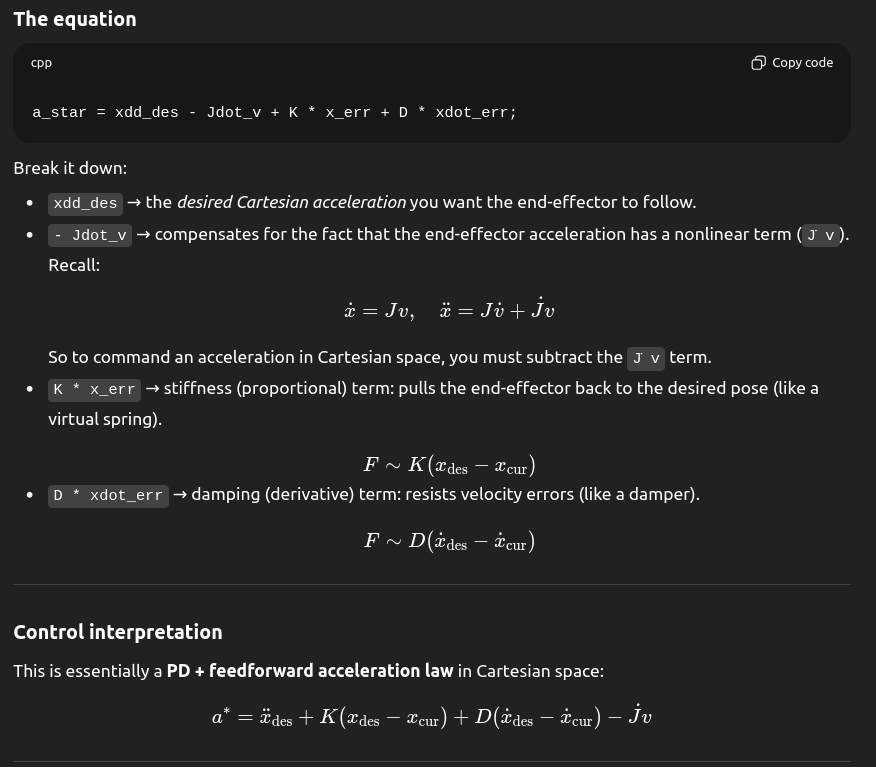

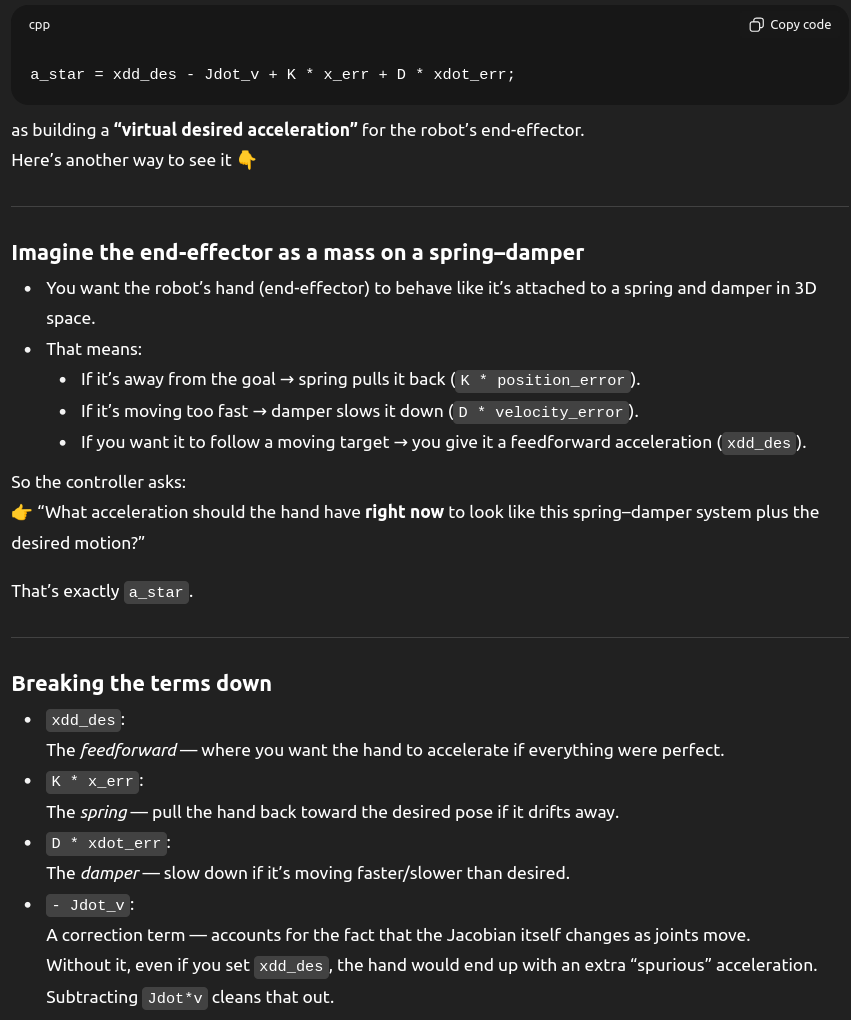

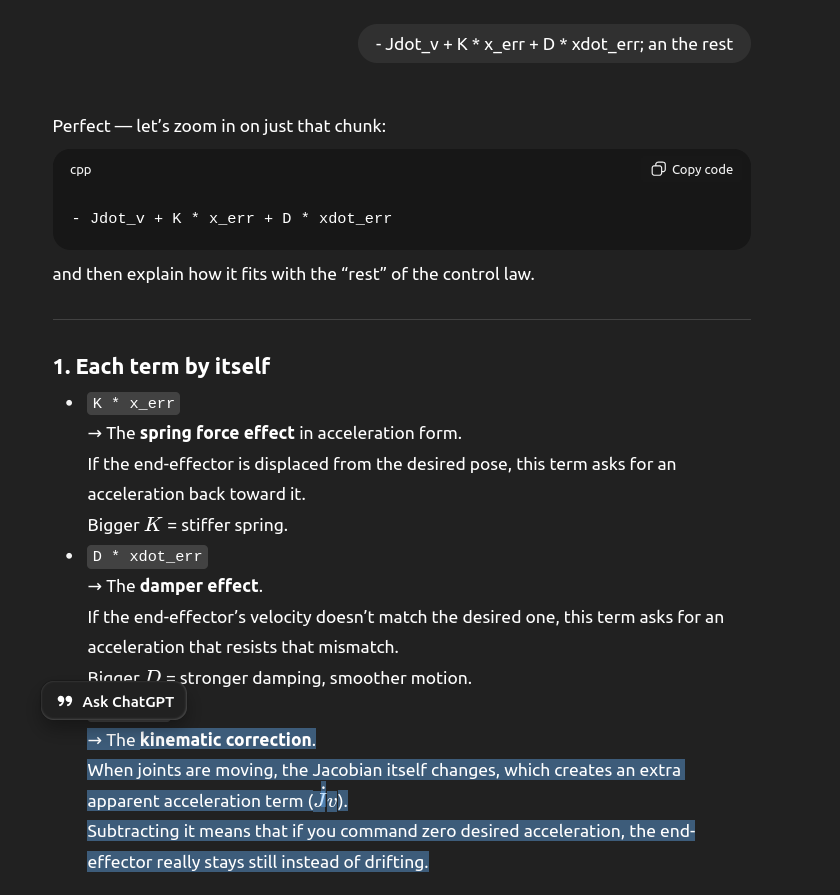

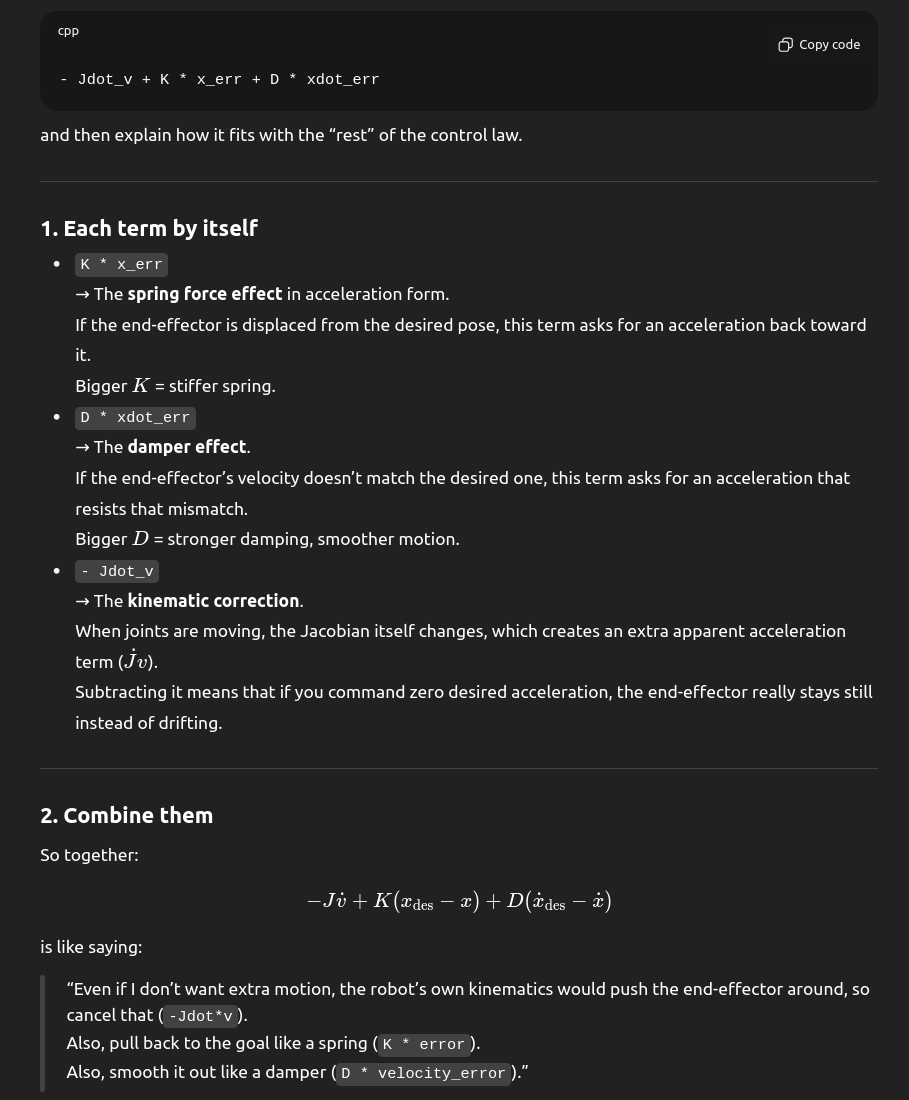